# Homework 04: Regression for Bike Sharing

## Section 1.0: Importing Libraries

### Description
This code imports the needed libraries for the project. 
- #### [statsmodels][statsmodelsid] is a Python module that provides classes and functions for the estimation of many different statistical models, as well as for conducting statistical tests, and statistical data exploration. 
- #### [sklearn][sklearnid] is the machine learning Python library for doing predictive data analysis. 
[sklearnid]: https://scikit-learn.org/stable/index.html "sklearn docs"
[statsmodelsid]: https://www.statsmodels.org/stable/index.html "statsmodels docs"



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


plt.style.use('ggplot')
%matplotlib inline

### Summary
- All of the libraries imported without issue.
- I made the decision to import all necessary libraries needed for the code here, as it is easier to reference this document later to see if I used the library in this code. 
- 'ggplot' is Grammar of Graphics plotting style, chosen for its aesthetic 

## Section 1.1: Data Preparation

### Description
- In this section, the df_bike dataframe is created from the bikeday.csv file. 
- Some of the df_bike dataframe's columns are transformed to discrete sets of values, such as 0 and 1 or 1,2,3,4. 
- Some columns are converted into dummy variable columns, which enumerate the various entries into their own columns. For example, the day_of_week columns includes values for each day, and when converted to a dummy variable, each day gets a column. 
- The columns converted to dummy variables are then dropped. 

In [2]:
df_bike = pd.read_csv('data/bikeday.csv', index_col=None, header=0)

In [3]:
# Transform the bikes_avail_min column to 1 or 0 in new columns "bikes_out"
def bike_out(d): 
    if d['bikes_avail_min'] == 0: 
        return 1
    else: 
        return 0

df_bike['bikes_out'] = df_bike.apply(bike_out, axis = 1); #applies the function to the column

In [4]:
# Events column (Rain -Thunderstorm 4, Rain - Fog 3, Rain - 2, Fog - 1, None - 0)
def weather(d): 

    if d['events'] == 'Rain-Thunderstorm': 
        return 4
    elif d['events'] == 'Fog-Rain': 
        return 3
    elif d['events'] == 'Rain':
        return 2
    elif d['events'] == 'Fog': 
        return 1
    else: 
        return 0

df_bike['events'] = df_bike.apply(weather, axis = 1); #applies the function to the column
df_bike['events'] = pd.DataFrame(df_bike['events']) #saves the series as a dataframe. 

In [5]:
# day_of_week (Dummy variables)
dummies_dow = pd.get_dummies(df_bike['day_of_week'], drop_first = False)
df_bike = pd.concat([df_bike, dummies_dow], axis=1)

In [6]:
# zip_code (dummy variables)
dummies_zip = pd.get_dummies(df_bike['zip_code'], drop_first = False)
df_bike = pd.concat([df_bike, dummies_zip], axis=1) #concatenate together

In [7]:
# Drop zip_code, day_of_week. 
df_bike = df_bike.drop(['day_of_week','zip_code'], axis = 1)

### Summary
- This code prepares the data to be analyzed via regression. 
- The act of converting some columns from an infinite number of values to a standard set of values was a new technique for me, and is incredibly useful for analysis. 
- Using functions to convert column values, as well as the creation of dummy variable columns was also interesting. 
- The ouput of this section is a df_bike dataset that has removed null values and includes quantifiable columns in the place of non-quantifiable values. 

## Section 1.2: Simple Linear Regression with Scikit-Learn
#### Predicting the trip_time_sum based on the mean temperature

### Description
- In this section, a simple linear regression model is created to compare mean temperature to trip times. 
- Using the sklearn LinearRegression function, and the .fit() .predict() methods, the relationship between the two values is meassured and plotted. 
-  the mean_squared_error comparing y to predictions shows the average squared difference between the outcome and the ones predicted by the model. 
- the r2 score shows the proportion of the variance in trip_time_sum values that is explained by the mean temperature. 

In [8]:
# create df_bike_reg from df_bike
df_bike_reg = df_bike.drop(['date','start_station_id','bikes_out'], axis=1)
# drop the date, start_station_id, and bikes_out columns from df_bike_reg

In [9]:
# Create a new X variable from df_bike_reg['mean_temperature_f']
X = df_bike_reg[['mean_temperature_f']]


In [10]:
# Create a new y variable from df_bike_reg['trip_time_sum'] (Be sure to reshape using y= y.values.reshape(-1,1))
y = df_bike_reg[['trip_time_sum']]


In [11]:
X = X.values.reshape(-1,1) #reshape to a range of -1 to 1
y = y.values.reshape(-1,1) #reshape to a range of -1 to 1

In [12]:
reg = LinearRegression() #create a linear regression model

In [13]:
reg.fit(X,y) #fit the model

LinearRegression()

In [14]:
predictions = reg.predict(X) #generates predictions

In [15]:
# mean_squared_error showing the amount of error between the predictions and the y values
mean_squared_error(y,predictions)

327566.3145176107

In [16]:
# The r^2 score shows the variability explained by the relationship
r2_score(y,predictions)

0.0006129431291654885

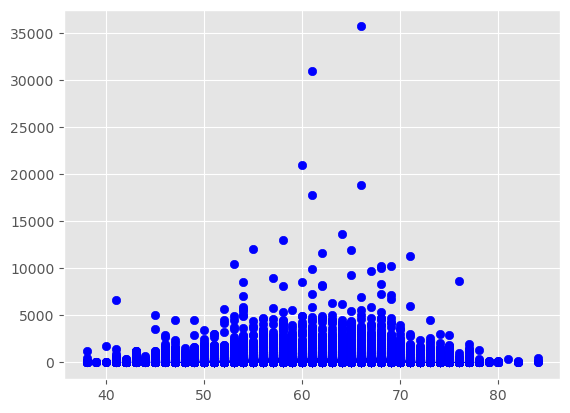

In [17]:
# Run a scatter plot with X as x, y as y. 
plt.scatter(X,y,color="blue")


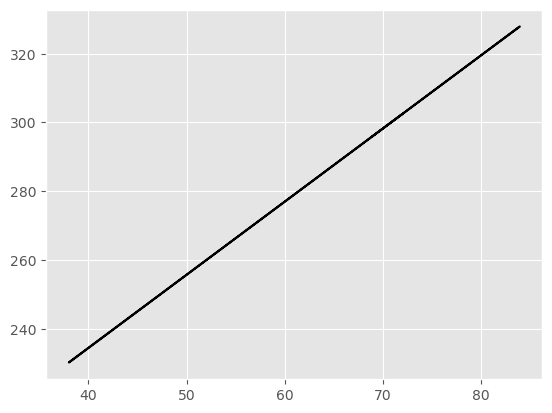

In [18]:
# Plot the relationship between the X value and the predictions. Should be linear. 
plt.plot(X, predictions, color="black")

### Summary

- This code showed how to perform and display simple linear regression models. 

- The mean squared error value indicates the amount of error between the linear regression model and the test data. The closer to 0, the better, so it is likely that this model is not very good at predicting values. 

- For R^2, the .0006 value is much lower than an ideal of >.6. Therefore, the mean temperature explains almost none of the variability in the data. 

- The scatter plot shows a somewhat normally distributed set, with some outlier values. Therefore, as the temperatures are at lower and higher extremes, people appear to be spending less time on their bikes. This could simply be due to the date range, or the normal range of temperatures in this location. This may be why the model is not finding a strong relationship between the values. 

- The plot of X and predictions is linear and is actually composed of many dots. I believe that this is useful for analyzing the relationship between the independent variable and the predictions, and if it is not done correctly, it does not portray a perfect linear relationship. In this case it does. 


## Section 1.3: Multiple Regression and Backward Elimination

### Description
- This section performs mulitple regression, comparing ten features and then producing summary statistics to determine if any of them are unneccessary. 
- This section uses statsmodels, which performs oridinary least squares and creates the multiple regression model from it. 
- The unneccessary features are removed from the model, and the remaining features are used to provide an ideal sized model for performing multiple regression. 

In [19]:
df_bike_reg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40844 entries, 0 to 40843
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   trip_time_sum         40844 non-null  int64  
 1   trip_count            40844 non-null  int64  
 2   subscribe_%           40844 non-null  float64
 3   station_id            40844 non-null  int64  
 4   bikes_avail_median    40844 non-null  float64
 5   docks_avail_median    40844 non-null  float64
 6   bikes_avail_min       40844 non-null  int64  
 7   dock_count            40844 non-null  int64  
 8   docks_avail_min       40844 non-null  int64  
 9   max_temperature_f     40844 non-null  int64  
 10  mean_temperature_f    40844 non-null  int64  
 11  min_temperature_f     40844 non-null  int64  
 12  mean_dew_point_f      40844 non-null  int64  
 13  mean_humidity         40844 non-null  int64  
 14  max_wind_Speed_mph    40844 non-null  int64  
 15  mean_wind_speed_mph

In [20]:
# Run a multiple regression named 'est'
est = smf.ols(formula='trip_time_sum ~ trip_count + bikes_avail_median + dock_count + docks_avail_median + mean_temperature_f + mean_humidity + mean_wind_speed_mph + precipitation_inches + cloud_cover + events', data = df_bike_reg).fit()

In [21]:
# Analyze the summar statistics and eliminate all non-significant models;
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          trip_time_sum   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     852.7
Date:                Wed, 14 Feb 2024   Prob (F-statistic):               0.00
Time:                        18:00:12   Log-Likelihood:            -3.1380e+05
No. Observations:               40844   AIC:                         6.276e+05
Df Residuals:                   40834   BIC:                         6.277e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             -137.6198     35.397     -3.888      0.000    -206.998     -68.241
trip_count              12.1793      0.158     76.994      0.000      11.869      12.489
bikes_avail_median       2.9675      0.505      5.871      0.000       1.977       3.958
dock_count               2.1404      0.453      4.727      0.000       1.253       3.028
docks_avail_median      -0.8270      0.480     -1.723      0.085      -1.768       0.114
mean_temperature_f       1.1780      0.417      2.825      0.005       0.361       1.995
mean_humidity            1.1886      0.316      3.764      0.000       0.570       1.807
mean_wind_speed_mph      5.4627      0.836      6.536      0.000       3.825       7.101
precipitation_inches   -23.4031     18.887     -1.239      0.215     -60.422      13.616
cloud_cover             -7.0998      1.531     -4.636      0.000     -10.101      -4.098
events                 -13.4755      4.348     -3.099      0.002     -21.997      -4.954
==============================================================================
Omnibus:                    93945.739   Durbin-Watson:                   1.949
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       1765998948.967
Skew:                          22.060   Prob(JB):                         0.00
Kurtosis:                    1020.722   Cond. No.                     1.16e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.79e-24. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [22]:
est1 = smf.ols(formula='trip_time_sum ~ trip_count + bikes_avail_median + dock_count + mean_temperature_f + mean_humidity + mean_wind_speed_mph + cloud_cover + events', data = df_bike_reg).fit()

In [23]:
# Analyze the model without the values where p > .05
est1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          trip_time_sum   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     959.1
Date:                Wed, 14 Feb 2024   Prob (F-statistic):               0.00
Time:                        18:00:12   Log-Likelihood:            -3.1380e+05
No. Observations:               40844   AIC:                         6.276e+05
Df Residuals:                   40835   BIC:                         6.277e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            -138.2430     35.393     -3.906      0.000    -207.615     -68.871
trip_count             12.1977      0.157     77.450      0.000      11.889      12.506
bikes_avail_median      3.7700      0.875      4.307      0.000       2.054       5.486
dock_count              1.3163      0.784      1.678      0.093      -0.221       2.854
mean_temperature_f      1.2122      0.416      2.914      0.004       0.397       2.028
mean_humidity           1.1845      0.316      3.751      0.000       0.566       1.803
mean_wind_speed_mph     5.3280      0.829      6.430      0.000       3.704       6.952
cloud_cover            -7.2384      1.527     -4.740      0.000     -10.232      -4.245
events                -15.1475      4.133     -3.665      0.000     -23.249      -7.046
==============================================================================
Omnibus:                    93946.860   Durbin-Watson:                   1.948
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       1766195038.849
Skew:                          22.061   Prob(JB):                         0.00
Kurtosis:                    1020.778   Cond. No.                     1.30e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.3e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [24]:
# New model without the values where p > .05
est2 = smf.ols(formula='trip_time_sum ~ trip_count + bikes_avail_median + mean_temperature_f + mean_humidity + mean_wind_speed_mph + cloud_cover + events', data = df_bike_reg).fit()

In [25]:
# Analyze the final model without all variables with p-value greater than .05
est2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          trip_time_sum   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     1096.
Date:                Wed, 14 Feb 2024   Prob (F-statistic):               0.00
Time:                        18:00:12   Log-Likelihood:            -3.1380e+05
No. Observations:               40844   AIC:                         6.276e+05
Df Residuals:                   40836   BIC:                         6.277e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            -121.1776     33.902     -3.574      0.000    -187.626     -54.729
trip_count             12.2539      0.154     79.631      0.000      11.952      12.556
bikes_avail_median      4.5090      0.756      5.960      0.000       3.026       5.992
mean_temperature_f      1.1830      0.416      2.846      0.004       0.368       1.998
mean_humidity           1.1985      0.316      3.797      0.000       0.580       1.817
mean_wind_speed_mph     5.3907      0.828      6.512      0.000       3.768       7.013
cloud_cover            -7.2448      1.527     -4.744      0.000     -10.238      -4.251
events                -15.1819      4.133     -3.673      0.000     -23.283      -7.081
==============================================================================
Omnibus:                    93956.240   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       1767759011.761
Skew:                          22.066   Prob(JB):                         0.00
Kurtosis:                    1021.229   Cond. No.                     1.22e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.22e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Summary
- Multiple regression splits the set into X (ten features which are not trip_time_sum) and y (trip_time_sum) 
- The model is created via the smf.ols method, and provides statistical information about the nature of each feature. 
- The original model, est, shows that two features have p-values >.05, which indicates that the feature is not statistically significant in generating the model. These features are [docks_avail_median] and [preciptitation_inces]. They are removed from the new model, est1. 
- est1 shows an additional feature with a p-value >.05, dock_count. It is also removed. 
- est2 returns a model with no p-values >.05. This is the largest feature set that is statistically significant out of the features I originally chose. 
- The coef values provide the model's intercept and coefficient, if the value for trip_time_sum was to be mapped or calculated according to each of the values. 
- Ultimately, this code demonstrated how to perform multiple regression and the use statistical analysis to eliminate unnessary features from a model using p-values. 

## Section 1.4: Lasso Regression with Scikit-Learn

### Description
- In this section, lasso regression is performed using Scikit-Learn's Lasso function. 
- The dataset is scaled, and then split into training and testing sets. 
- The optimal alpha value is calculated, and then used. 
- The lasso regression is performed on the training data and then used to predict the test data. 
- A score is provided for the lasso regression, and a dataframe is created showing the features and their coefficients. 

In [26]:
# Create X from df_bike_reg by dropping trip_time_sum and trip_count
X = df_bike_reg.drop(['trip_time_sum','trip_count'], axis = 1)

In [27]:
# Create y from df_bike_reg['trip_time_sum']
y = df_bike_reg['trip_time_sum']

In [28]:
# Scale the X variable and name it X_reg_scaled
scaler = StandardScaler()
X.columns = X.columns.astype(str)
X_reg_scaled = scaler.fit_transform(X)


In [29]:
# Split the data for test/train
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

iteration 1 done
iteration 2 done
iteration 3 done
iteration 4 done
iteration 5 done
iteration 6 done
iteration 7 done
iteration 8 done
iteration 9 done
iteration 10 done


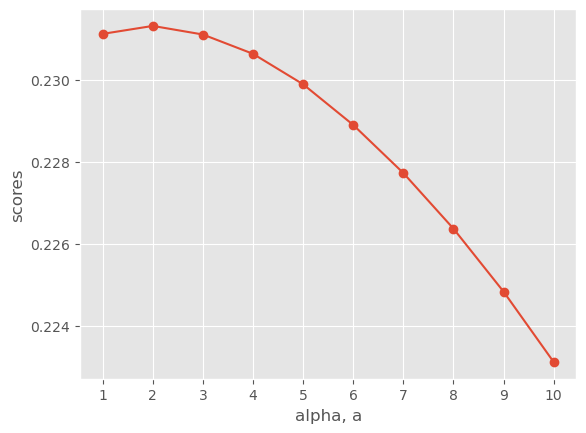

In [30]:
# Run a function to find the best alpha
alphas = [1,2,3,4,5,6,7,8,9,10] #approximate the alpha value
scores = []

for a in alphas: 
    lasso = Lasso(alpha = a)
    lasso.fit(X_train, y_train)
    scores.append(lasso.score(X_test, y_test))
    print("iteration {} done".format(a))

plt.plot(alphas, scores, '-o')
plt.xlabel('alpha, a')
plt.ylabel('scores')
plt.xticks(alphas)
plt.show()

iteration 1.5 done
iteration 1.75 done
iteration 2 done
iteration 2.25 done
iteration 2.5 done


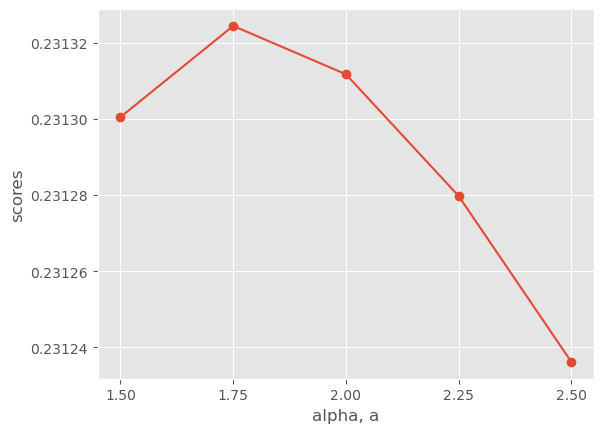

In [31]:
# Run a function to find the best alpha
alphas = [1.5,1.75,2,2.25,2.5] #find the optimal alpha from the previous graph
scores = []

for a in alphas: 
    lasso = Lasso(alpha = a)
    lasso.fit(X_train, y_train)
    scores.append(lasso.score(X_test, y_test))
    print("iteration {} done".format(a))

plt.plot(alphas, scores, '-o')
plt.xlabel('alpha, a')
plt.ylabel('scores')
plt.xticks(alphas)
plt.show()

In [32]:
# Using lasso, conduct a regression
lasso = Lasso(alpha=1.75) #set the alpha to 1.75, normalize is deprecated. 
lasso.fit(X_train, y_train)
lasso_pred = lasso.predict(X_test)
lasso.score(X_test,y_test)


0.23132439803264215

In [33]:
# Create a dataframe that shows the name and coefficient of features
names = X.columns
lasso_coef = lasso.fit(X,y).coef_ # save the coefficients to a series

In [34]:
df_lasso = pd.DataFrame([lasso_coef]) #place the coefficients in a dataframe

In [35]:
df_lasso.columns = names
df_lasso = df_lasso.T #transpose the columns
df_lasso = df_lasso.rename(columns = {0:'corr_coeff'}) #rename the 0 column to corr_coeff
df_lasso

,corr_coeff
subscribe_%,-578.691626
station_id,0.740152
bikes_avail_median,19.531438
docks_avail_median,0.000000
bikes_avail_min,-42.052539
dock_count,24.229334
docks_avail_min,-22.200612
max_temperature_f,-0.220159
mean_temperature_f,-0.000000
min_temperature_f,0.933195


### Summary
- This code showed how to perform a lasso regression and then display the results. 
- The model is first standardized with StandardScaler, and then split into training and testing data. This is done so that there is a set to train the data on and a set to test it's predictions against. 
- The lasso regression method requires an alpha penalty value, which introduces a certain degree of bias into the dataset to account for overfitting. The optimal alpha value was calculated, first in a rough way and then in a more fine manner, to arrive at an optimal value of 1.75. This alpha value is then used when conducting the lasso regression. 
- The resulting score of the lasso regression is .231324... meaning it accounts for about 23% of the variance of the dependent variable using the features. This is lower than the .6 threshold mentioned in the Professor's videos, and indicates that the model could likely be improved in some way to train a more useful model. 
- The dataframe that results shows which features had there coefficients reduced to 0, which is a key feature of the lasso regression method. Those features that did not have their coefficient's reduced to 0 are calculated to have a degree of influence on the trip time. 

## Section 1.5: Ridge Regression with Scikit-Learn

### Description
- This code shows how to create a Ridge regression. 
- The code calculates an optimal alpha value for the Ridge regression, and then runs the regression using the training data. 
- The code then generates predictions for the testing data using the trained model, and is then scored. 
- The coefficients of each feature is then provided in a dataframe. 

iteration 0.1 done
iteration 1 done
iteration 2 done
iteration 3 done
iteration 4 done
iteration 5 done
iteration 6 done
iteration 7 done
iteration 8 done
iteration 9 done
iteration 10 done


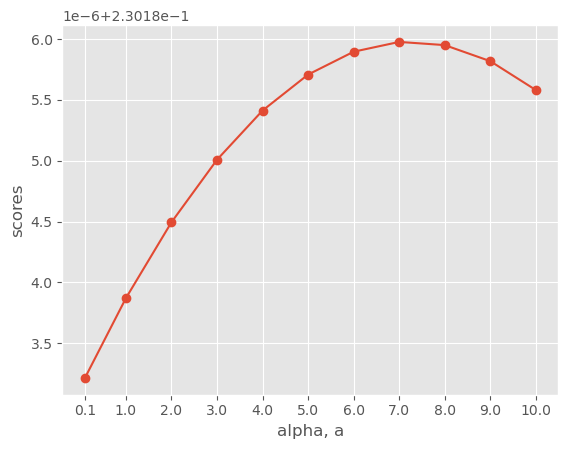

In [36]:
# Using ridge, conduct a regression
alphas = [0.1, 1,2,3,4,5,6,7,8,9,10] # use a rough approach to approximate the alpha value. 
scores = []
for a in alphas: 
    ridge = Ridge(alpha = a)
    ridge.fit(X_train, y_train)
    scores.append(ridge.score(X_test, y_test))
    print("iteration {} done".format(a))
    
plt.plot(alphas,scores, '-o')
plt.xlabel('alpha, a')
plt.ylabel('scores')
plt.xticks(alphas)
plt.show()

iteration 6.5 done
iteration 6.75 done
iteration 7 done
iteration 7.25 done
iteration 7.5 done


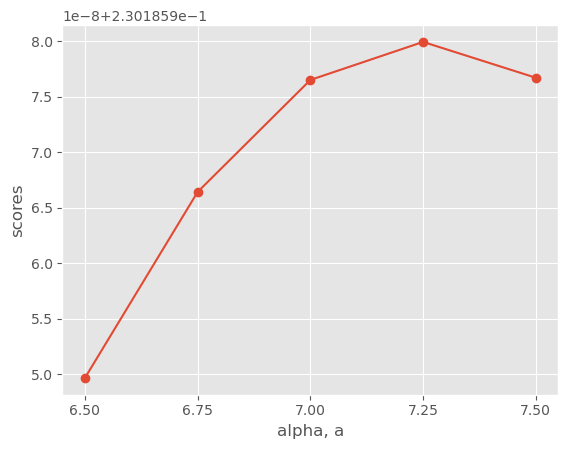

In [37]:
# Using ridge, conduct a regression
alphas = [6.5,6.75,7,7.25,7.5] # use a more refined approach to find the best alpha value
scores = []
for a in alphas: 
    ridge = Ridge(alpha = a)
    ridge.fit(X_train, y_train)
    scores.append(ridge.score(X_test, y_test))
    print("iteration {} done".format(a))
    
plt.plot(alphas,scores, '-o')
plt.xlabel('alpha, a')
plt.ylabel('scores')
plt.xticks(alphas)
plt.show()

In [38]:
ridge = Ridge(alpha=7.25) # set the alpha to 7.25. The normalize command is deprecated. 
ridge.fit(X_train, y_train) # fit the model to the training data
ridge_pred = ridge.predict(X_test) #predict the test values

In [39]:
ridge.score(X_test, y_test) #compare the results with the actual values

0.23018597994309653

In [40]:
# Create a dataframe that shows the name of the feature and coefficients
ridge_coef = ridge.fit(X,y).coef_ #save the coefficients of the ridge model into a new ridge_coef variable

df_ridge = pd.DataFrame(ridge_coef).T # create a new dataframe from the coefficients, and then transpose the dataframe
df_ridge.columns = names # Sets the columns to the list of names of features
df_ridge = df_ridge.T # transposes the dataframe again. 
df_ridge = df_ridge.rename(columns = {0:'corr_coeff'})
df_ridge # displays the dataframe

,corr_coeff
subscribe_%,-626.115838
station_id,0.690161
bikes_avail_median,21.381462
docks_avail_median,1.786653
bikes_avail_min,-42.796982
dock_count,23.168116
docks_avail_min,-22.886175
max_temperature_f,-0.526513
mean_temperature_f,0.194890
min_temperature_f,-0.124767


### Summary
- This code showed how to perform a Ridge regression and then display the results. 
- The Ridge regression method requires an alpha penalty value, which introduces a certain degree of bias into the dataset to account for overfitting. The optimal alpha value was calculated, first in a rough way and then in a more fine manner, to arrive at an optimal value of 7.25. This alpha value is then used when conducting the Ridge regression. 
- The resulting score of the lasso regression is .23018597994309653... meaning it accounts for about 23% of the variance of the dependent variable using the features. This is lower than the .6 value mentioned in the Professor's videos, and indicates that the model could likely be improved in some way to train a more useful model. 
- The dataframe that results shows the coefficients of the features, which are all greater than 0. This is the aspect of Ridge regression that differs from lasso regression. The largest absolute coefficient values are more weighty on the model then those closer to 0. 

## Section 1.6: Summary of the results

- About the tests 
     - Simple linear regression 
         - This test compared one independent variable, mean temperature with the dependent variable of trip time, and showed that it did not have a significant relationship. 
         - This method of analyzing relationships is simple, and has limitations due to only considering the relationship between one feature and the dependent variable. The simplicity makes the computation less than the other models and could be preferable when the interpretation of a relationship between two variables is more important than understanding a complex, multivariable model. 
     - Multiple regression & Backward Elimination
         - This test split the data into X, 10 of the most appropriate non-trip-time variables, and y, trip time. 
         - The resulting model, est, showed which variables were statistically significant and which weren't. First, the mean number of docks available and the amount of precipitation were shown to be insufficient, and were removed. The second round demonstrated that number of docks was also statistically insignificant. 
         - est2, the model with all significant features, was still a rather poor model due to its R-squared value being .158. That means that less than 16% of the variance is explained by the model. 
         - This method of analyzing relationships is interesting, and given a better set of variables, it is possible that the value cold eventually reach .6, which is good according to Professor Apigian. 
      - Lasso Regresion 
           - This test standardized the data, and then split it into training and testing data. It then calculated the appropriate alpha penalty to introduce bias into the model. This was done to increase the fit of the model to the test data. 
           - Lasso regression eliminates the weight of some features, which helps build a more streamlined model with less features. The resulting score was ~.23, which means that the model accounted for around 23% of the variability. Much lower than then 60% needed for an acceptable model. 
           - The test was interesting because it could be very useful when building a model with the minimum number of features for the maximum accuraccy. 
       - Ridge Regression 
            - This test calculated its own alpha penalty, and then used it to build a model with bias. Unlike the lasso regression, it does not eliminate any features, but increases and decreases the weight of features. 
            - This test indicated a similar 23% value for R^2, and is still a ways off from being a good enough model for use on any testing data. 
            - This test was useful to know, because there may be models were all of the features are neccesary for calculating the dependent varible. 
- About the results
    - Looking at the result of the multiple regression model, it appears that the number of trips, the weather events of the day (higher = less desirable), the amount of cloud cover, and the wind speed, all played role in the total trip time. This makes sense, as poor weather for biking would be the thing that keeps people from biking. These results are therefore not revolutionary in terms of their insight, simply that the worst the weather is, the higher the wind speeds are, and the degree of cloud cover, all negatively impact the amount of time spent riding bikes. 
    - The lasso regression model indicates that the subscription percentage had a heavy negative influence on the model. The higher the percentage of riders that were subscribers, the less time was spent riding. The minimum number of bikes and docks also had negative relationships, but this seems to be something directly related to the amount of time spent on bikes. The most interesting part of this model to me was the factor that Friday had on the model. It appears the Friday must be a time when bikes are accessed the most frequently. Given these findings, the day being Friday and having many docks available appear to be the two factors that add to trip time, while being a subscriber decreases trip time. 
    - The ridge regression model had similar results, but also included weighted values for the zip codes. The results indicate that some zip codes are a positive factor while others are negative. This may be due to the geography of their location, with more densely populated areas requiring less ride time overall. The days of the weekend also had different weights, with friday being the positive and sunday being a heavy negative. Like the lasso model, the subscription % also had a heavy negative pull on total trip time. 
    
- Conclusions
    - The models do not produce adequate accuracy to explain the data (23% is way less than 60%). 
    - Subscription % weighs negatively on total trip time. This is intersting to consider. Its likely subscribers are using the bikes for short, predetermined trips, while non-subscribers are paying for more meandering, single time trips. 
    - The weight of zip-codes in the Ridge model was interesting to consider, as the geographic distance is likely less in more densely populated areas. 
    - The factor of negative weather was noted in the multiple regression model, but played a much smaller role in the relatively more "explanatory" lasso and ridge regression models. 
   